# Metodo de Montecarlo

In [49]:
import sys
sys.path.append('..')
#Para poder leer los modulos dentro del directorio 
from Codigo.opcion_europea_bs import opcion_europea_bs
from Codigo.opcion_europea_mc import opcion_europea_mc

import numpy as np
import math

opcion_europea_mc
Def
    Calculador del precio de una opcion Europea con el modelo de MonteCarlo
Inputs
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
    - pasos : int - Cantidad de caminos de montecarlo
Outputs
    - precio_MC: float - Precio del contrato


In [50]:
#Inicializo los parametros

tipo = "CALL"
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.25
div = 0

In [51]:
#Tomo un vector de normales aleatorias
pasos = 1000000 
z = np.random.normal(0,1,pasos)
#print(z)


In [52]:
opcion = np.zeros(pasos) #En el ppt. C = C_i

In [53]:
for i in range(0,pasos):
    if tipo == "CALL":
        payoff = max( 0 , S * math.exp((r-div - 0.5 * math.pow(sigma,2)) * T + sigma * math.sqrt(T)  * z[i]) - K) # max(0,S_i-K)
    elif tipo == "PUT":
        payoff = max(0, K - S * math.exp((r-div - 0.5 * math.pow(sigma, 2)) * T + sigma * math.sqrt(T) * z[i]) )
    opcion[i] = math.exp(-r * T) * payoff #C_i


In [54]:
precio_MC = np.mean(opcion)

precio_MC

desvio = math.sqrt(np.var(opcion)/pasos)

print("precio",precio_MC)
print("desvio", desvio)

precio 12.367346809403712
desvio 0.018546260591117806


### Convergencia del metodo

In [55]:
tipo = "CALL"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.0

pasos_vec = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,40,50,75,100,125,150,200,250,300, 500]      
precios = np.zeros(len(pasos_vec))

for index in range(len(pasos_vec)):
    precios[index] = opcion_europea_mc(tipo, S, K, T, r, sigma, div, pasos_vec[index])
 
precio_BS = opcion_europea_bs(tipo, S, K, T, r, sigma, div)

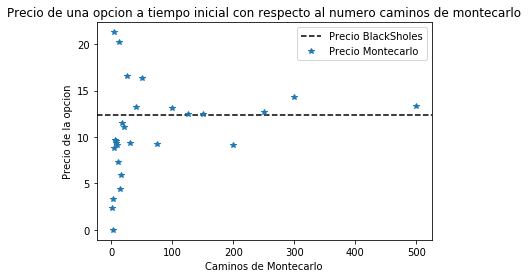

In [56]:
from matplotlib import pyplot as plt
plt.axhline(y=precio_BS, color = 'black', linestyle='--', label='Precio BlackSholes')
plt.plot(pasos_vec,precios,'*', label='Precio Montecarlo')

plt.legend()

plt.xlabel('Caminos de Montecarlo')
plt.ylabel('Precio de la opcion')
plt.title('Precio de una opcion a tiempo inicial con respecto al numero caminos de montecarlo')

plt.show()

# Metodo de diferencias finitas

In [57]:
from Codigo.opcion_americana_fd import opcion_americana_fd
from Codigo.opcion_europea_fd import opcion_europea_fd

from scipy.interpolate import interp1d

opcion_europea_fd
Def
    Calculador del precio de una opcion Europea con el modelo de Diferencias Finitas (metodo explicito)
Inputs
    - tipo : string - Tipo de contrato entre ["CALL","PUT"]
    - S : float - Spot price del activo
    - K : float - Strike price del contrato
    - T : float - Tiempo hasta la expiracion (en años)
    - r : float - Tasa 'libre de riesgo' (anualizada)
    - sigma : float - Volatilidad implicita (anualizada)
    - div : float - Tasa de dividendos continuos (anualizada)
Outputs
    - precio_FD: float - Precio del contrato

In [58]:
tipo = "CALL"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0.0

In [59]:
#Hadrcode de la grilla de diferencias finitas
M = 160
N = 1600
dS = 2 * S / M
dt = T / N

In [60]:
# Grilla de spots y tiempos
S_vec = np.linspace(0, 2*S, M+1)
t_vec = np.linspace(0, T, N+1)

In [61]:
# Armado de la matriz tridiagonal
j = np.arange(1,M)
j2 = np.zeros(M-1)
aj = np.zeros(M-1)
bj = np.zeros(M-1)
cj = np.zeros(M-1)

for index in range(0,M-1):
    sigma2 = sigma*sigma
    j2[index] = j[index] * j[index]
    aj[index] = 0.5 * dt * (sigma2 * j2[index]- (r-div) * j[index])
    bj[index] = 1-dt * (sigma2 * j2[index] + r)
    cj[index] = 0.5 * dt * (sigma2 * j2[index] + (r-div) * j[index])

In [62]:
# Matriz tridiagonal

A = np.diag(bj)
for index in range(0, M - 2):
    A[index + 1, index] = aj[index + 1]  # terms below the diagonal
    A[index, index + 1] = cj[index]  # terms above the diagonal

In [63]:
# Matriz de precios de la opcion
opcion_precios = np.zeros((M+1,N+1)) #V

In [64]:
#Condiciones de contorno

# Condicion final - Payoff

if tipo == "CALL":
    opcion_precios[:,-1] = np.maximum(S_vec - K, 0)
elif tipo == "PUT":
    opcion_precios[:,-1] = np.maximum(K - S_vec, 0)

In [65]:
# Casos limite en S=0 y S~inf

if tipo == "CALL":
    opcion_precios[0, :] = 0
    opcion_precios[-1, :] = S_vec[-1]*np.exp(-div*np.flip(t_vec)) - K * np.exp(-r*np.flip(t_vec))
elif tipo == "PUT":
    opcion_precios[0, :] = K * np.exp(-r * np.flip(t_vec))
    opcion_precios[-1, :] = 0 #K * np.exp(-r * np.flip(t_vec))

In [66]:
    
# Calculo en el interior
# variable auxiliar para sumar en la primer y ultimo fila
constantes_bordes = np.array((aj[0], cj[-1]))
for i in list(reversed(range(0,N))):

    opcion_precios[1:M,i] = A @ opcion_precios[1:M,i+1]
    #Offset the first and last terms
    opcion_precios[[1,M-1],i] = opcion_precios[[1,M-1],i] + constantes_bordes * opcion_precios[[0, M],i+1];

In [67]:
#En este punto ya esta TODA la grilla, ahora calculo lo requerido

f = interp1d(S_vec,opcion_precios[:,0])
precio_FD = float(f(S))

S=100
precio_FD


12.33380258723264

In [68]:
from mpl_toolkits import mplot3d

X, Y = np.meshgrid(t_vec, S_vec)
Z = opcion_precios

In [69]:
print('X', np.shape(X))
print('Y', np.shape(Y))
print('Z', np.shape(Z))

X (161, 1601)
Y (161, 1601)
Z (161, 1601)


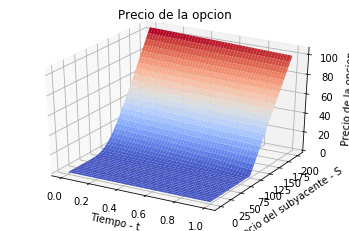

In [70]:
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm')#, edgecolor='none')#rstride=1, cstride=1,
                

ax.set_title('Precio de la opcion');
ax.set_xlabel('Tiempo - t')
ax.set_ylabel('Precio del subyacente - S')
ax.set_zlabel('Precio de la opcion')

plt.show()

# QuantLib o Introduccion a una Verdadera plataforma de pricing/riesgo

In [71]:
from QuantLib import *
#%matplotlib inline

from Codigo.utils_plots import *
import QuantLib as ql

### Opciones

### Supongamos una opcion de AAPL con precio strike de 450 expirando el 16 de octubre de 2020. Supongamos que el spot es 440. La vol implicita es sabida que es 31%, y tiene un dividendo de 0.75%. Valuemos la opcion al dia de hoy (10 de Agosto 2020)

#### Definimos los inputs

In [72]:
S = 456.30
K = 460
sigma = 0.3394 # the historical vols for a year
div =  0.075
r = 0.0013

option_type = ql.Option.Call

option_type

1

#### Para las fechas QuantLib es mas preciso. Pide convenciones y calendarios

In [73]:
maturity_date = ql.Date(16, 10, 2020)
calculation_date = ql.Date(6, 8, 2020)

day_count = ql.Actual365Fixed()


ql.Argentina()
calendar = ql.UnitedStates()
ql.Settings.instance().evaluationDate = calculation_date


maturity_date

Date(16,10,2020)

#### Aqui construimos a la opcion europea

In [74]:
payoff = ql.PlainVanillaPayoff(option_type, K)

exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)



#### Aca constuimos el proceso de Black Sholes Merton

##### El objeto spot

In [75]:
spot_obj = ql.QuoteHandle(SimpleQuote(S))

In [76]:
spot_obj.value()

456.3

##### El objeto curva de descuento (flat en este caso, constante)

In [77]:
rate_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                            r, 
                                                    day_count))

##### El objeto curva de dividendos (flat en este caso, constante)

In [78]:
dividend_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                      div, 
                                                      day_count))

##### El objeto volatilidad (flat en este caso, constante)

In [79]:
vol_obj = ql.BlackVolTermStructureHandle(BlackConstantVol(calculation_date, 
                                                                 calendar, 
                                                                 sigma, 
                                                             day_count))

In [80]:
##### El proceso propiamente dicho

In [81]:
bsm_process = ql.BlackScholesMertonProcess(spot_obj, 
                                        dividend_obj, 
                                        rate_obj, 
                                        vol_obj)

## Modelos de precio

###  `AnalyticEuropeanEngine` (Black Scholes)

In [82]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))

bs_price = european_option.NPV()
print("El precio teorico usando el modelo de BS es: ", bs_price)

El precio teorico usando el modelo de BS es:  22.340433141477693


###  `FdBlackScholesVanillaEngine` (Diferencias Finitas)

In [83]:
european_option.setPricingEngine(ql.FdBlackScholesVanillaEngine(bsm_process))

fd_price = european_option.NPV()
print("El precio teorico usando el modelo de Dif. Finitas es: ", fd_price)

El precio teorico usando el modelo de Dif. Finitas es:  22.350546907886763


###  `MCEuropeanEngine` (Montecarlo)

In [84]:
european_option.setPricingEngine(ql.MCEuropeanEngine(bsm_process, "PseudoRandom", timeSteps=20, requiredSamples=500000))

mc_price = european_option.NPV()
print("El precio teorico usando el modelo de MonteCarlo es: ",  mc_price)

El precio teorico usando el modelo de MonteCarlo es:  22.2516125206562


###  `BinomialVanillaEngine` (Binomial)

In [85]:
european_option.setPricingEngine(ql.BinomialVanillaEngine(bsm_process, "crr", 1000))

bin_price = european_option.NPV()
print("El precio teorico usando el modelo Binomial es: ",  bin_price)

El precio teorico usando el modelo Binomial es:  22.340372556198265


# Comparacion de TODOS* los modelos vistos (caso de juguete)

### Fijo los parametros

In [86]:
S = 100
K = 100
sigma = 0.25 # the historical vols for a year
div =  0.0
r = 0.05

tipo = 'CALL'

option_type = Option.Call

maturity_date = ql.Date(10, 8, 2021)
calculation_date = ql.Date(10, 8, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
ql.Settings.instance().evaluationDate = calculation_date

T = 1



## Pricers vistos en clase

### Importo los pricers vistos en clase

In [87]:
from Codigo.opcion_europea_bs import opcion_europea_bs
from Codigo.opcion_europea_mc import opcion_europea_mc
from Codigo.opcion_europea_fd import opcion_europea_fd
from Codigo.opcion_europea_bin import opcion_europea_bin

import timeit

### Corro cada uno de los pricers (les tomo el tiempo de ejecucion tambien)

In [88]:
start = timeit.default_timer()
precio_bs = opcion_europea_bs(tipo, S, K, T, r, sigma, div)
end = timeit.default_timer()
tiempo_bs = end - start


start = timeit.default_timer()
precio_bin = opcion_europea_bin(tipo, S, K, T, r, sigma, div, 5000)
end = timeit.default_timer()
tiempo_bin = end - start

start = timeit.default_timer()
precio_mc = opcion_europea_mc(tipo, S, K, T, r, sigma, div, 500000)
end = timeit.default_timer()
tiempo_mc = end - start

start = timeit.default_timer()
precio_fd = opcion_europea_fd(tipo, S, K, T, r, sigma, div)
end = timeit.default_timer()
tiempo_fd = end - start

## Precios QuantLib

### Seteo lo necesario en QuantLib

In [89]:
payoff = ql.PlainVanillaPayoff(option_type, K)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_obj = ql.QuoteHandle(SimpleQuote(S))

rate_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                            r, 
                                                    day_count))

dividend_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                      div, 
                                                      day_count))

vol_obj = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, 
                                                                 calendar, 
                                                                 sigma, 
                                                             day_count))

bsm_process = ql.BlackScholesMertonProcess(spot_obj, 
                                        dividend_obj, 
                                        rate_obj, 
                                        vol_obj)



### Corro cada uno de los pricers (les tomo el tiempo de ejecucion tambien)

In [90]:

start = timeit.default_timer()
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
end = timeit.default_timer()
time_bs = end - start

start = timeit.default_timer()
european_option.setPricingEngine(ql.FdBlackScholesVanillaEngine(bsm_process))
fd_price = european_option.NPV()
end = timeit.default_timer()
time_fd = end - start

start = timeit.default_timer()
european_option.setPricingEngine(ql.MCEuropeanEngine(bsm_process, "PseudoRandom", timeSteps=20, requiredSamples=500000))
mc_price = european_option.NPV()
end = timeit.default_timer()
time_mc = end - start

start = timeit.default_timer()
european_option.setPricingEngine(ql.BinomialVanillaEngine(bsm_process, "crr", 5000))
bin_price = european_option.NPV()
end = timeit.default_timer()
time_bin = end - start



### Imprimo TODO

In [91]:
print("Precio modelo Europea BS visto en clase:", precio_bs)
print("Tiempo modelo Europea BS visto en clase:", tiempo_bs)

print("Precio modelo Europea Binomial visto en clase:", precio_bin)
print("Tiempo modelo Europea Binomial visto en clase:", tiempo_bin)

print("Precio modelo Europea Montecarlo visto en clase:", precio_mc)
print("Tiempo modelo Europea Montecarlo visto en clase:", tiempo_mc)

print("Precio modelo Europea Dif. Finitas visto en clase:", precio_fd)
print("Tiempo modelo Europea Dif. Finitas visto en clase:", tiempo_fd)


print("Precio modelo Europea BS QuantLib", bs_price)
print("Tiempo modelo Europea BS QuantLib:", time_bs)

print("Precio modelo Europea Binomial QuantLib:", bin_price)
print("Tiempo modelo Europea Binomial QuantLib:", time_bin)

print("Precio modelo Europea Montecarlo QuantLib:", mc_price)
print("Tiempo modelo Europea Montecarlo QuantLib:", time_mc)

print("Precio modelo Europea Dif. Finitas QuantLib:", fd_price)
print("Tiempo modelo Europea Dif. Finitas QuantLib:", time_fd)

Precio modelo Europea BS visto en clase: 12.335998930368717
Tiempo modelo Europea BS visto en clase: 0.00034540000001470617
Precio modelo Europea Binomial visto en clase: 12.33550453323051
Tiempo modelo Europea Binomial visto en clase: 18.251568500000076
Precio modelo Europea Montecarlo visto en clase: 12.339955229413347
Tiempo modelo Europea Montecarlo visto en clase: 0.7595950999998422
Precio modelo Europea Dif. Finitas visto en clase: 12.33380258723264
Tiempo modelo Europea Dif. Finitas visto en clase: 0.04840209999997569
Precio modelo Europea BS QuantLib 12.335998930368715
Tiempo modelo Europea BS QuantLib: 0.0001142999999501626
Precio modelo Europea Binomial QuantLib: 12.335493341380698
Tiempo modelo Europea Binomial QuantLib: 0.061644099999966784
Precio modelo Europea Montecarlo QuantLib: 12.324207511680399
Tiempo modelo Europea Montecarlo QuantLib: 3.0627256000000216
Precio modelo Europea Dif. Finitas QuantLib: 12.343995358859775
Tiempo modelo Europea Dif. Finitas QuantLib: 0.00

### Tabla de precios por modelo

| Precio | Clase | QuantLib |
| --- | --- | --- |
| BS | 12.336 | 12.336 |
| Binomial | 12.33355 | 12.33347 |
| Montecarlo | _12.33747_ | _12.38694_ |
| Dif.Finitas | 12.33380 | 12.34399 |

### Tabla de tiempos de ejecucion por modelo

| Tiempo | Clase | QuantLib |
| --- | --- | --- |
| BS | **0.00033** | **0.00023** |
| Binomial | 17.38176 | **0.06012** |
| Montecarlo | **0.72694** | 3.03739 |
| Dif.Finitas | 0.046359 | **0.001721** |

### Opciones Americanas


In [92]:
S = 100
K = 100
sigma = 0.25 # the historical vols for a year
div =  0.0
r = 0.05
tipo = 'CALL'

option_type = Option.Put

maturity_date = ql.Date(10, 8, 2021)
calculation_date = ql.Date(10, 8, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
ql.Settings.instance().evaluationDate = calculation_date

T = 1


In [93]:
payoff = ql.PlainVanillaPayoff(option_type, K)

am_exercise = AmericanExercise(calculation_date, maturity_date)
american_option = VanillaOption(payoff, am_exercise)

In [94]:
spot_obj = ql.QuoteHandle(SimpleQuote(S))

rate_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                            r, 
                                                    day_count))

dividend_obj = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                                                      div, 
                                                      day_count))

vol_obj = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, 
                                                                 calendar, 
                                                                 sigma, 
                                                             day_count))

bsm_process = ql.BlackScholesMertonProcess(spot_obj, 
                                        dividend_obj, 
                                        rate_obj, 
                                        vol_obj)

In [95]:
# No hay Black Scholes
american_option.setPricingEngine(BinomialVanillaEngine(bsm_process, "crr", 1000))
bin_price_ame = american_option.NPV()

american_option.setPricingEngine(ql.FdBlackScholesVanillaEngine(bsm_process))
fd_price_ame = american_option.NPV()

american_option.setPricingEngine(ql.MCAmericanEngine(bsm_process, "PseudoRandom", timeSteps=20, requiredSamples=500000))
mc_price_ame = american_option.NPV()



In [96]:
american_option.setPricingEngine(AnalyticEuropeanEngine(bsm_process))
bin_price_ame = american_option.NPV()

RuntimeError: not an European option

In [97]:
from Codigo.opcion_americana_bin import opcion_americana_bin
from Codigo.opcion_americana_fd import opcion_americana_fd

In [98]:
tipo = "PUT"
precio_bin_ame = opcion_americana_bin(tipo, S, K, T, r, sigma, div, 1000)
precio_fd_ame = opcion_americana_fd(tipo, S, K, T, r, sigma, div)


In [99]:
print("Precio modelo Amercana Binomial visto en clase:", precio_bin_ame)
print("Precio modelo Amercana Dif. Finitas visto en clase:", precio_fd_ame)

print("Precio modelo Amercana Binomial QuantLib:", bin_price_ame)
print("Precio modelo Amercana Montecarlo QuantLib:", mc_price_ame)
print("Precio modelo Amercana Dif. FinitasQuantLib:", fd_price_ame)

Precio modelo Amercana Binomial visto en clase: 7.973040110898395
Precio modelo Amercana Dif. Finitas visto en clase: 7.972112289334249
Precio modelo Amercana Binomial QuantLib: 7.973463892545318
Precio modelo Amercana Montecarlo QuantLib: 7.836109428138963
Precio modelo Amercana Dif. FinitasQuantLib: 7.966283110785785


# BONUS TRACK - GUI Para calculadora

Les dejo un codigo usando el modulo **tkinter** que pide los inputs de los modelos y llama a los pricers vistos en clase 

In [100]:
from tkinter import *

from Codigo.opcion_europea_bin import opcion_europea_bin
from Codigo.opcion_europea_bin_c import opcion_europea_bin_c
from Codigo.opcion_europea_fd import opcion_europea_fd
from Codigo.opcion_europea_mc import opcion_europea_mc
from Codigo.opcion_europea_bs import opcion_europea_bs

from Codigo.opcion_americana_fd import opcion_americana_fd
from Codigo.opcion_americana_bin import opcion_americana_bin

class MyWindow:
    def __init__(self, win):

        self.lbl_ejercicio = Label(win, text='Tipo de Ejercicio: ')
        self.lbl_ejercicio.place(x=10, y=40)

        self.ejercicio_lbl = IntVar()
        self.ejercicio_lbl.set(1)
        r1 = Radiobutton(window, text="Europea", variable=self.ejercicio_lbl, value=1)
        r2 = Radiobutton(window, text="Americana", variable=self.ejercicio_lbl, value=2)
        r1.place(x=150, y=40)
        r2.place(x=250, y=40)

        self.lbl_tipo = Label(win, text='Tipo de contrato: ')
        self.lbl_tipo.place(x=10, y=80)

        self.tipo_lbl = IntVar()
        self.tipo_lbl.set(1)
        r1 = Radiobutton(window, text="CALL", variable=self.tipo_lbl, value=1)
        r2 = Radiobutton(window, text="PUT", variable=self.tipo_lbl, value=2)
        r1.place(x=150, y=80)
        r2.place(x=250, y=80)

        self.lbl1 = Label(win, text='Precio Spot -                                            S :')
        self.lbl2 = Label(win, text='Precio de ejercicio -                                K : ')
        self.lbl3 = Label(win, text='Tiempo de expiracion en años -           T : ')
        self.lbl4 = Label(win, text='Tasa libre de riesgo anualizada -           r : ')
        self.lbl5 = Label(win, text='Volatilidad implicita anualizada - sigma: ')
        self.lbl6 = Label(win, text='Tasa de dividendos anualizada -       div: ')

        self.lbloutput = Label(win, text='Precio de la opcion:')
        self.lblvar_mc = Label(win, text='Varianza de MC:')


        self.S_lbl = Entry()
        self.K_lbl = Entry()
        self.T_lbl = Entry()
        self.r_lbl = Entry()
        self.sigma_lbl = Entry()
        self.div_lbl = Entry()

        self.output = Entry()
        #self.var_mc = Entry()

        self.lbl1.place(x=10, y=150)
        self.S_lbl.place(x=225, y=150)

        self.lbl2.place(x=10, y=175)
        self.K_lbl.place(x=225, y=175)

        self.lbl3.place(x=10, y=200)
        self.T_lbl.place(x=225, y=200)

        self.lbl4.place(x=10, y=225)
        self.r_lbl.place(x=225, y=225)

        self.lbl5.place(x=10, y=250)
        self.sigma_lbl.place(x=225, y=250)

        self.lbl6.place(x=10, y=275)
        self.div_lbl.place(x=225, y=275)

        self.modelo_lbl = IntVar()
        self.modelo_lbl.set(1)
        r1 = Radiobutton(window, text="Black Scholes", variable=self.modelo_lbl, value=1)
        r2 = Radiobutton(window, text="Binomial", variable=self.modelo_lbl, value=2)
        r3 = Radiobutton(window, text="Montecarlo", variable=self.modelo_lbl, value=3)
        r4 = Radiobutton(window, text="Diferencias Finitas", variable=self.modelo_lbl, value=4)

        r1.place(x=50, y=320)
        r2.place(x=150, y=320)
        r3.place(x=250, y=320)
        r4.place(x=350, y=320)

        self.b1 = Button(win, text='Calcular precio opcion', command=self.calculate)
        self.b1.place(x=175, y=375)

        self.lbloutput.place(x=10, y=425)
        self.output.place(x=225, y=425)

        #self.lblvar_mc.place(x=10, y=475)
        #self.var_mc.place(x=225, y=475)

        self.S_lbl.insert(END, 100.0)
        self.K_lbl.insert(END, 100.0)
        self.T_lbl.insert(END, 1)
        self.r_lbl.insert(END, 0.05)
        self.sigma_lbl.insert(END, 0.25)
        self.div_lbl.insert(END, 0.0)

    def calculate(self):
        #borro lo que habia
        self.output.delete(0, 'end')
        #inicializo
        if self.tipo_lbl.get() == 1:
            tipo = "CALL"
        elif self.tipo_lbl.get() == 2:
            tipo = "PUT"

        #Inputs
        S=float(self.S_lbl.get())
        K=float(self.K_lbl.get())
        T = float(self.T_lbl.get())
        r = float(self.r_lbl.get())
        sigma = float(self.sigma_lbl.get())
        div = float(self.div_lbl.get())

        if self.modelo_lbl.get() == 1:
            if self.ejercicio_lbl.get() ==1:
                precio = opcion_europea_bs(tipo, S, K, T, r, sigma, div)
            elif self.ejercicio_lbl.get() ==2:
                precio = 'NA'
            else:
                precio = 'Error'

        elif self.modelo_lbl.get() == 2 :

            if self.ejercicio_lbl.get() == 1:
                pasos = 1000
                precio = opcion_europea_bin_c(tipo, S, K, T, r, sigma, div, pasos)
            elif self.ejercicio_lbl.get() == 2:
                pasos = 1500
                precio = opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos)
            else:
                precio = 'Error'
        elif self.modelo_lbl.get() == 3 :
            pasos = 100000
            if self.ejercicio_lbl.get() == 1:
                precio = opcion_europea_mc(tipo, S, K, T, r, sigma, div, pasos)

         #       try:
         #           self.var_mc.insert(END, round(var, 4))
         #       except:
         #           self.var_mc.insert(END, var)

            elif self.ejercicio_lbl.get() ==2:
                precio = 'NA'
            else:
                precio ='Error'
        elif self.modelo_lbl.get() == 4 :
            if self.ejercicio_lbl.get() == 1:
                precio = opcion_europea_fd(tipo, S, K, T, r, sigma, div)
            elif self.ejercicio_lbl.get() == 2:
                precio = opcion_americana_fd(tipo, S, K, T, r, sigma, div)
            else:
                precio = 'Error'
        else:
            precio = 'Error'
        try:
            self.output.insert(END, round(precio,4))
        except:
            self.output.insert(END, precio)

window=Tk()
mywin=MyWindow(window)
window.title('Calculadora Opciones - UCEMA QUANt 2020')
window.geometry("500x600+15+15")
window.mainloop()